<a href="https://colab.research.google.com/github/Nannanpeng/Econ_Dynamic_Programming/blob/master/Job_search_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade quantecon

Requirement already up-to-date: quantecon in /usr/local/lib/python3.6/dist-packages (0.4.8)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from numba import njit, jitclass, float64
from quantecon.distributions import BetaBinomial

## Exercise 1

In [3]:
@njit
def u(c, σ=2.0):
    return (c**(1 - σ) - 1) / (1 - σ)

In [4]:
n = 60                                  # n possible outcomes for w
w_default = np.linspace(10, 20, n)      # wages between 10 and 20
a, b = 600, 400                         # shape parameters
dist = BetaBinomial(n-1, a, b)
q_default = dist.pdf()

In [5]:
mccall_data = [
    ('α', float64),      # job separation rate
    ('β', float64),      # discount factor
    ('c', float64),      # unemployment compensation
    ('w', float64[:]),   # list of wage values
    ('q', float64[:])    # pmf of random variable w
]

@jitclass(mccall_data)
class McCallModel:
    """
    Stores the parameters and functions associated with a given model.
    """

    def __init__(self, α=0.2, β=0.98, c=6.0, w=w_default, q=q_default):

        self.α, self.β, self.c, self.w, self.q = α, β, c, w, q


    def update(self, v, d):

        α, β, c, w, q = self.α, self.β, self.c, self.w, self.q

        v_new = np.empty_like(v)

        for i in range(len(w)):
            v_new[i] = u(w[i]) + β * ((1 - α) * v[i] + α * d)

        d_new = np.sum(np.maximum(v, u(c) + β * d) * q)

        return v_new, d_new

In [6]:
@njit
def solve_model(mcm, tol=1e-5, max_iter=2000):
    """
    Iterates to convergence on the Bellman equations

    * mcm is an instance of McCallModel
    """

    v = np.ones_like(mcm.w)    # Initial guess of v
    d = 1                      # Initial guess of d
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        v_new, d_new = mcm.update(v, d)
        error_1 = np.max(np.abs(v_new - v))
        error_2 = np.abs(d_new - d)
        error = max(error_1, error_2)
        v = v_new
        d = d_new
        i += 1
    if i >= max_iter:
      raise ValueError('Iteration failed.')
    return v, d

In [7]:
def compute_reservation_wage(mcm):
    """
    Computes the reservation wage of an instance of the McCall model
    by finding the smallest w such that v(w) >= h.

    If no such w exists, then w_bar is set to np.inf.
    """

    v, d = solve_model(mcm)
    h = u(mcm.c) + mcm.β * d

    w_bar = np.inf
    for i, wage in enumerate(mcm.w):
        if v[i] > h:
            w_bar = wage
            break

    return w_bar

In [8]:
grid_size = 25
c_vals = np.linspace(2, 12, grid_size)         # unemployment compensation
beta_vals = np.linspace(0.8, 0.99, grid_size)  # discount factors
alpha_vals = np.linspace(0.05, 0.5, grid_size) # separation rate

In [9]:
%%time
storage = np.empty((3, grid_size))
for i, vals in enumerate([c_vals, beta_vals, alpha_vals]):
  mcm = McCallModel()
  for j, val in enumerate(vals):
    if i == 0:
      mcm.c = val
    elif i == 1:
      mcm.β = val
    else:
      mcm.α = val
    w_bar = compute_reservation_wage(mcm)
    storage[i, j] = w_bar

CPU times: user 2.03 s, sys: 22.3 ms, total: 2.06 s
Wall time: 2.06 s


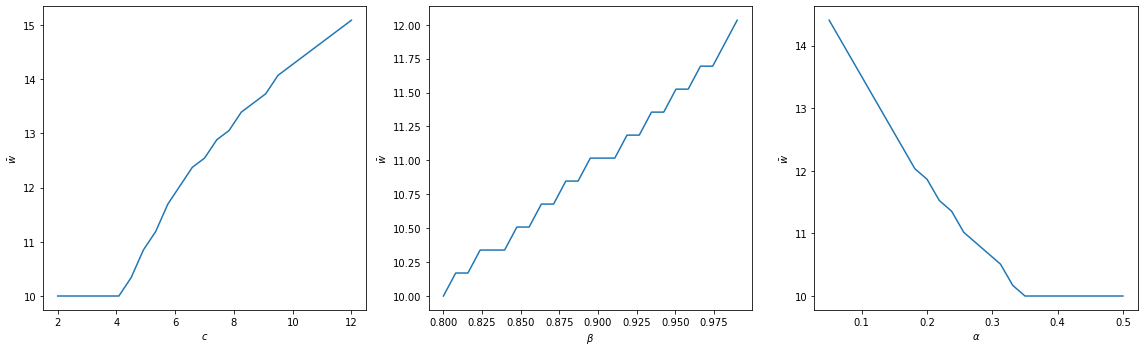

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for w, val, ax, xlabel in zip(storage, [c_vals, beta_vals, alpha_vals], \
                  axes.flatten(), ['$c$', r"$\beta$", r'$\alpha$']):
  ax.plot(val, w)
  ax.set(xlabel=f'{xlabel}', ylabel=r'$\bar{w}$')
fig.tight_layout()